In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
from matplotlib import pyplot as plt

cuda_available = torch.cuda.is_available()

In [0]:
# standardization code
standardizator = transforms.Compose([transforms.ToTensor(), ])

# MNIST dataset
train_data = dsets.MNIST(root='data/', train=True, transform=standardizator, download=True)
test_data  = dsets.MNIST(root='data/', train=False, transform=standardizator, download=True)


batch_size = 200
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

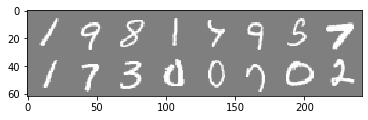

In [3]:
def imshow(img):
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img): 
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
example_mini_batch_img, example_mini_batch_label  = next(iter(train_data_loader))
imshow_grid(example_mini_batch_img[0:16,:,:])

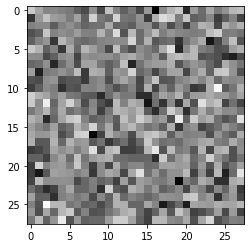

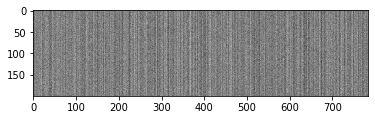

In [4]:
d_noise  = 100
d_hidden = 256

def sample_z(batch_size = 1, d_noise=100):
    return torch.randn(batch_size, d_noise, device=device)

class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        conv2d_1 = torch.nn.Conv2d()
        conv2d_2 = torch.nn.Conv2d()
        conv2d_3 = torch.nn.Conv2d()

        self.ConvModule = torch.nn.Sequential(
            conv2d_1,
            torch.nn.LeakyReLU(),
            Conv2d_2,
            torch.nn.LeakyReLU(),
            Conv2d_3
        )

        self.fc = torch.nn.Linear(, 784)

        if cuda_available:
            self.ConvModule = self.ConvModule.cuda()
            self.fc = self.fc.cuda()

G = nn.Sequential(
    nn.Linear(d_noise, d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden,d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, 28*28),
    nn.Tanh()
).to(device)

G = nn.Sequential(
    nn.Conv2d(),
    nn.LeakyReLU(),
    nn.Conv2d(),
    nn.LeakyReLU(),
    nn.Conv2d(),
    nn.LeakyReLU(),
)

# 노이즈 생성하기
z = sample_z()
# 가짜 이미지 생성하기
img_fake = G(z).view(-1,28,28)
# 이미지 출력하기
imshow(img_fake.squeeze().cpu().detach())

# Batch SIze만큼 노이즈 생성하여 그리드로 출력하기
z = sample_z(batch_size)
img_fake = G(z)
imshow_grid(img_fake)

In [5]:
D = nn.Sequential(
    nn.Linear(28*28, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, 1),
    nn.Sigmoid()
).to(device)

print(G(z).shape)
print(D(G(z)).shape)
print(D(G(z)[0:5]).transpose(0,1))

torch.Size([200, 784])
torch.Size([200, 1])
tensor([[0.4855, 0.4875, 0.4850, 0.4859, 0.4882]], device='cuda:0',
       grad_fn=<TransposeBackward0>)


In [0]:
criterion = nn.BCELoss()

def run_epoch(generator, discriminator, _optimizer_g, _optimizer_d):
    
    generator.train()
    discriminator.train()

    for img_batch, label_batch in train_data_loader:
        
        img_batch, label_batch = img_batch.to(device), label_batch.to(device) 

        # ================================================  #
        # maximize V(discriminator,generator) = optimize discriminator (setting k to be 1)  #
        # ================================================  #

        # init optimizer
        _optimizer_d.zero_grad()

        p_real = discriminator(img_batch.view(-1, 28*28))
        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))

        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #
        #loss_real = -1 * torch.log(p_real)   # -1 for gradient ascending
        #loss_fake = -1 * torch.log(1.-p_fake) # -1 for gradient ascending
        #loss_d    = (loss_real + loss_fake).mean()
        
        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        loss_d = criterion(p_real, torch.ones_like(p_real).to(device)) + criterion(p_fake, torch.zeros_like(p_real).to(device))       #
        
        # Update parameters
        loss_d.backward()
        _optimizer_d.step()

        # ================================================  #
        #        minimize V(discriminator,generator)        #
        # ================================================  #

        # init optimizer
        _optimizer_g.zero_grad()

        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))
                
        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #
        
        # instead of: torch.log(1.-p_fake).mean() <- explained in Section 3
        #loss_g = -1 * torch.log(p_fake).mean() 

        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        loss_g = criterion(p_fake, torch.ones_like(p_fake).to(device)) #

        loss_g.backward()
   
        # Update parameters
        _optimizer_g.step()
          
def evaluate_model(generator, discriminator):
    
    p_real, p_fake = 0.,0.
    
    generator.eval()
    discriminator.eval()
        
    for img_batch, label_batch in test_data_loader:
        
        img_batch, label_batch = img_batch.to(device), label_batch.to(device) 
        
        with torch.autograd.no_grad():
            p_real += (torch.sum(discriminator(img_batch.view(-1, 28*28))).item())/10000.
            p_fake += (torch.sum(discriminator(generator(sample_z(batch_size, d_noise)))).item())/10000.
            
            
    return p_real, p_fake

0
1
2
3
4
5
6
7
8
9
(epoch 10/200) p_real: 0.985076, p_g: 0.008169


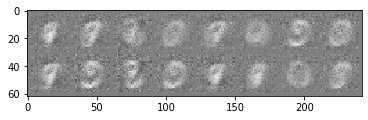

10
11
12
13
14
15
16
17
18
19
(epoch 20/200) p_real: 0.984775, p_g: 0.004393


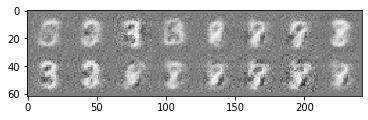

20
21
22
23
24
25
26
27
28
29
(epoch 30/200) p_real: 0.983896, p_g: 0.029020


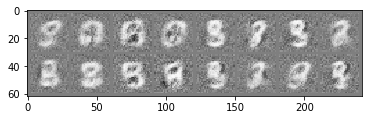

30
31
32
33
34
35
36
37
38
39
(epoch 40/200) p_real: 0.972254, p_g: 0.016882


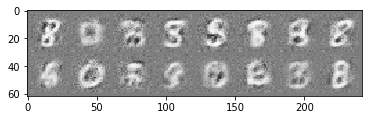

40
41
42
43
44
45
46
47
48
49
(epoch 50/200) p_real: 0.950945, p_g: 0.032080


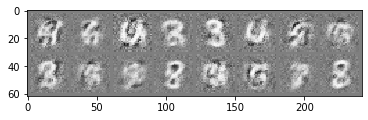

50
51
52
53
54
55
56
57
58
59
(epoch 60/200) p_real: 0.969684, p_g: 0.054564


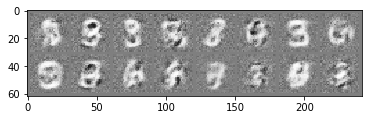

60
61
62
63
64
65
66
67
68
69
(epoch 70/200) p_real: 0.936000, p_g: 0.043898


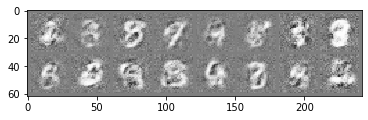

70
71
72
73
74
75
76
77
78
79
(epoch 80/200) p_real: 0.921798, p_g: 0.057520


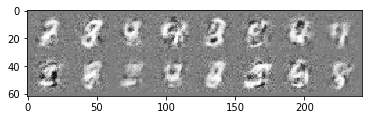

80
81
82
83
84
85
86
87
88
89
(epoch 90/200) p_real: 0.916239, p_g: 0.069090


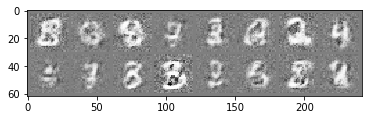

90
91
92
93
94
95
96
97
98
99
(epoch 100/200) p_real: 0.874843, p_g: 0.087719


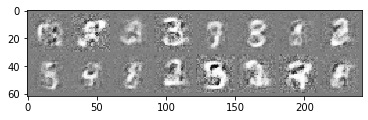

100
101
102
103
104
105
106
107
108
109
(epoch 110/200) p_real: 0.835056, p_g: 0.111220


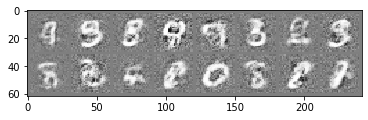

110
111
112
113
114
115
116
117
118
119
(epoch 120/200) p_real: 0.820915, p_g: 0.118343


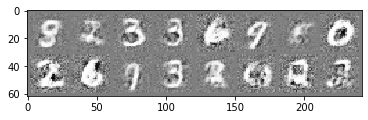

120
121
122
123
124
125
126
127
128
129
(epoch 130/200) p_real: 0.826479, p_g: 0.133995


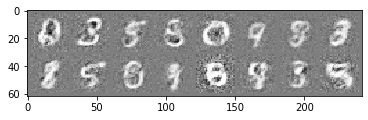

130
131
132
133
134
135
136
137
138
139
(epoch 140/200) p_real: 0.812962, p_g: 0.100625


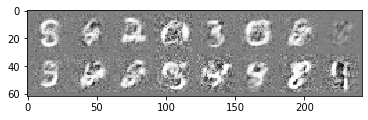

140
141
142
143
144
145
146
147
148
149
(epoch 150/200) p_real: 0.803797, p_g: 0.115748


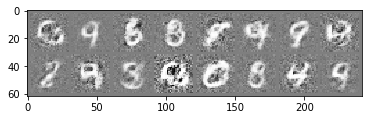

150
151
152
153
154
155
156
157
158
159
(epoch 160/200) p_real: 0.826273, p_g: 0.108477


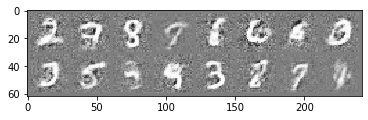

160
161
162
163
164
165
166
167
168
169
(epoch 170/200) p_real: 0.765114, p_g: 0.135296


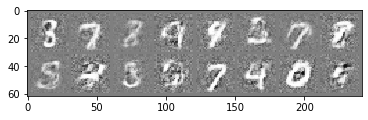

170
171
172
173
174
175
176
177
178
179
(epoch 180/200) p_real: 0.774610, p_g: 0.146417


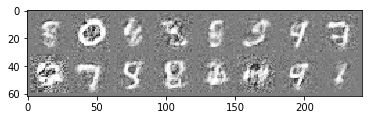

180
181
182
183
184
185
186
187
188
189
(epoch 190/200) p_real: 0.782852, p_g: 0.136361


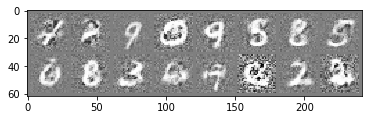

190
191
192
193
194
195
196
197
198
199
(epoch 200/200) p_real: 0.770098, p_g: 0.142320


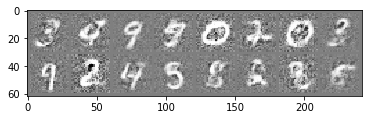

In [12]:
def init_params(model):
    for p in model.parameters():
        if(p.dim() > 1):
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)

init_params(G)
init_params(D)

optimizer_g = optim.Adam(G.parameters(), lr = 0.0002)
optimizer_d = optim.Adam(D.parameters(), lr = 0.0002)

p_real_trace = []
p_fake_trace = []

for epoch in range(200):
    print(epoch)
    run_epoch(G, D, optimizer_g, optimizer_d)
    p_real, p_fake = evaluate_model(G,D)
    
    p_real_trace.append(p_real)
    p_fake_trace.append(p_fake) 
    
    if((epoch+1)% 10 == 0):
        print('(epoch %i/200) p_real: %f, p_g: %f' % (epoch+1, p_real, p_fake))
        imshow_grid(G(sample_z(16)).view(-1, 1, 28, 28))